<a href="https://colab.research.google.com/github/Ludvins/PAC_Bayes_Chernoff_MLL/blob/main/DIY-MontyHall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monty Hall problem (fragments of code originally from pgmpy.org)

First make sure that all necessary libraries are installed and imported (more information about pgmpy, including tutorials, can be found on https://pgmpy.org/):

In [8]:
#!pip install pgmpy

In [9]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

import networkx as nx
import matplotlib.pyplot as plt

---
The Monty Hall problem was just explained to you. Recall that there are three variables:

C, your choice of door

H, door opened by host

R, door with real prize

Each of these variables has 3 values (0,1,2) representing the three different doors.

---

We now first define the Bayesian network structure by passing the list of edges. We focus on the structure corresponding to option (IV) discussed. Feel free to change this to a different structure by adding or removing edges.

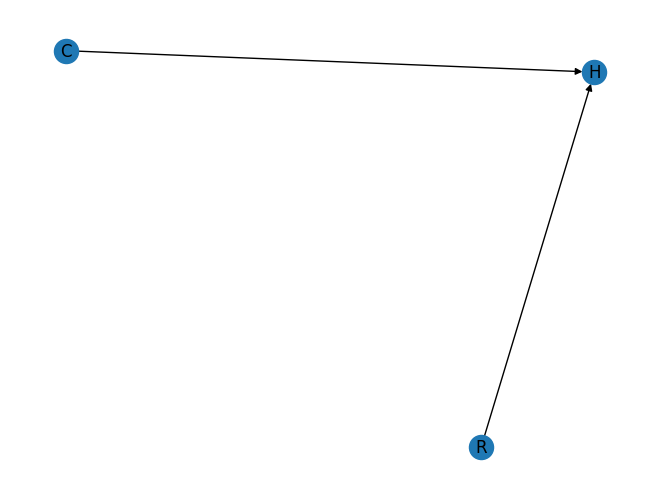

In [10]:
# Define network structure:
bn = BayesianNetwork()
bn.add_nodes_from(['C', 'H', 'R'])
bn.add_edges_from([('C','H'),('R','H')])

# Draw the last defined structure:
bngraph = nx.DiGraph(bn.edges())
nx.draw(bngraph, with_labels = True)
plt.show()

When the network structure is done, the associated (conditional) probability distributions have to be defined, using TabularCPD.

TabularCPD takes 5 arguments: the first is the variable name, followed by its cardinality (number of values), then a list with lists of probabilities; the evidence argument then provides a list of parents of the variable, followed by their cardinalities. The order in which the parents are listed in the evidence argument determines the order in which they are listed in the CPD: per value v of the variable (the columns in your table) there is a list of probabilities for v conditioned on all parent configurations (the rows in your table).

Let's add and check the CPDs for the defined structure.


In [11]:
# Define the CPD for variable 'C'
cpd_c = TabularCPD('C', 3, [ [1/3],
                             [1/3],
                             [1/3]  ],
                   evidence=[],
                   evidence_card=[] )


# Define the CPD for variable 'R'
cpd_r = TabularCPD('R', 3, [ [1/3],
                             [1/3],
                             [1/3] ],
                   evidence=[],
                   evidence_card=[] )



# Define the CPD for variable 'H'
# order of parent configurations: C=0,R=0; C=1,R=0; C=2,R=0; C=0,R=1; C=1,R=1; C=2,R=1; C=0,R=2; C=1,R=2; C=2,R=2
cpd_h = TabularCPD('H', 3, [ [0,0,0,0,1/2,1,0,1,1/2],
                             [1/2,0,1,0,0,0,1,0,1/2],
                             [1/2,1,0,1,1/2,0,0,0,0] ],
                   evidence= ['C','R'],
                   evidence_card= [3,3] )



# Associate the CPDs with the network structure:
bn.add_cpds(cpd_c,cpd_r,cpd_h)

# Return the defined CPDs
for i in bn.get_cpds():
    print(i)

+------+----------+
| C(0) | 0.333333 |
+------+----------+
| C(1) | 0.333333 |
+------+----------+
| C(2) | 0.333333 |
+------+----------+
+------+----------+
| R(0) | 0.333333 |
+------+----------+
| R(1) | 0.333333 |
+------+----------+
| R(2) | 0.333333 |
+------+----------+
+------+------+------+------+------+------+------+------+------+------+
| C    | C(0) | C(0) | C(0) | C(1) | C(1) | C(1) | C(2) | C(2) | C(2) |
+------+------+------+------+------+------+------+------+------+------+
| R    | R(0) | R(1) | R(2) | R(0) | R(1) | R(2) | R(0) | R(1) | R(2) |
+------+------+------+------+------+------+------+------+------+------+
| H(0) | 0.0  | 0.0  | 0.0  | 0.0  | 0.5  | 1.0  | 0.0  | 1.0  | 0.5  |
+------+------+------+------+------+------+------+------+------+------+
| H(1) | 0.5  | 0.0  | 1.0  | 0.0  | 0.0  | 0.0  | 1.0  | 0.0  | 0.5  |
+------+------+------+------+------+------+------+------+------+------+
| H(2) | 0.5  | 1.0  | 0.0  | 1.0  | 0.5  | 0.0  | 0.0  | 0.0  | 0.0  |


**Question:** consider the probabilities specified in the CPDs. What assumptions underly these numbers? Do you agree with them? Feel free to try some alternatives and see how that affects the probabilities that we will compute below. (Use the model check to verify that you still have a valid model if you do make changes)

In [12]:
# check the model structure and the associated CPDs: returns True if model syntax is correct otherwise throws an exception
bn.check_model()

True

Now that the model is specified we can compute probabilities from it. We can enter evidence into the network:
- the door of your choice (e.g. C=0 for the first door; change below if you want), and
- the door opened by the host (e.g. H=2 for the third door; change below if you want).

Then we compute the posterior distribution over R given the evidence to determine which door is most likely to have the real prize behind it.

Are you going to switch doors?

In [13]:
# Infering the posterior over R given C and H
infer = VariableElimination(bn)
posterior_r = infer.query(["R"], evidence={"C": 0, "H": 2})
print(posterior_r)

+------+----------+
| R    |   phi(R) |
+======+==========+
| R(0) |   0.3333 |
+------+----------+
| R(1) |   0.6667 |
+------+----------+
| R(2) |   0.0000 |
+------+----------+


We can also enter evidence for R and H and compute a posterior for C. What is the interpretation of this posterior?

In [14]:
# Infering the posterior over C given R and H
posterior_c = infer.query(["C"], evidence={"R": 1, "H": 2})
print(posterior_c)

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.6667 |
+------+----------+
| C(1) |   0.3333 |
+------+----------+
| C(2) |   0.0000 |
+------+----------+
